In [1]:
using LinearAlgebra
using Optim
using Plots

# Custom factorial function for BigFloat
function factorial_big(x::BigFloat)
    if x == BigFloat(0)
        return BigFloat(1.0)
    else
        return x * factorial_big(x - BigFloat(1))
    end
end

# Set up the points with BigFloat
p1 = BigFloat[0.0, 0.0]
p2 = BigFloat[1.0, 0.0]
p3 = BigFloat[0.0, 1.0]
# p3 = BigFloat[0.5, sqrt(BigFloat(3))/2]


m1 = (p2 .+ p3) ./ BigFloat(2.0)
m2 = (p1 .+ p3) ./ BigFloat(2.0)
m3 = (p1 .+ p2) ./ BigFloat(2.0)

b = (p1 .+ p2 .+ p3) ./ BigFloat(3.0)

# vertices
T1 = hcat(p1, p2, p3)
eval_T1(i, j) = T1[1, :] .^ BigFloat(i) .* T1[2, :] .^ BigFloat(j)

# edge midpoints
T2 = hcat(m1, m2, m3)
eval_T2(i, j) = T2[1, :] .^ BigFloat(i) .* T2[2, :] .^ BigFloat(j)

# midpoint
T3 = hcat(b)
eval_T3(i, j) = T3[1, :] .^ BigFloat(i) .* T3[2, :] .^ BigFloat(j)

# edge class
T4(a) = hcat(a * p1 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p1,
             a * p3 .+ (1 .- a) * p1,
             a * p1 .+ (1 .- a) * p3,
             a * p3 .+ (1 .- a) * p2,
             a * p2 .+ (1 .- a) * p3)

eval_T4(a, i, j) = T4(a)[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* T4(a)[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))


# inner class, type 1
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

eval_T5(a, i, j) = T5(a)[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* T5(a)[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))


# inner class, type 2 TODO!
T5(a) = hcat(a * m1 .+ (1 .- a) * p1, 
             a * m2 .+ (1 .- a) * p2, 
             a * m3 .+ (1 .- a) * p3)

T6(a,b) =  hcat(b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                b * (a * m1 .+ (1 - a) .* p1) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3),
                b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m2 .+ (1 - a) .* p2),
                b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                b * (a * m3 .+ (1 - a) .* p3) .+ (1 - b) * (a * m1 .+ (1 - a) .* p1),
                b * (a * m2 .+ (1 - a) .* p2) .+ (1 - b) * (a * m3 .+ (1 - a) .* p3))

eval_T6(a, b, i, j) = T6(a,b)[1, :] .^ (0 * (i < 0) + BigFloat(i) * (i >= 0)) .* T6(a,b)[2, :] .^ (0 * (j < 0) + BigFloat(j) * (j >= 0))




# Integral function using custom factorial_big
function integral(i, j)
    factorial_big(BigFloat(j)) * factorial_big(BigFloat(i)) / factorial_big(BigFloat(i + j + 2))
end

# System setup
function Aij(i, j, a)
    vcat(
        eval_T3(i, j), # trig midpoint
        sum(eval_T1(i, j)), # trig vertices
        eval_T2(i, j), # edge midpoints
        sum(eval_T4(a[1], i, j)),
        sum(eval_T5(a[2], i, j)),
        sum(eval_T6(a[3],a[4], i, j))
         )
end

A(a,order) = hcat([Aij(i, j, a) for i in 0:order for j in 0:order if i + j <= order]...)

# if the points p1,p2,p3 change then so must this integral
rhs(order) = vcat([integral(i, j) for i in 0:order for j in 0:order if i + j <= order]...)

rhs (generic function with 1 method)

In [2]:
order = 8
# f(a) = A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order)
f(a) = norm(A(a,order)'*((A(a,order) * A(a,order)')\(A(a,order) * rhs(order)))-rhs(order))

f (generic function with 1 method)

In [3]:
# rhs(6)

In [4]:
# Define the bounds
lower_bounds = BigFloat[0.0, 0.0, 0.0, 0.0]
upper_bounds = BigFloat[Inf, Inf, Inf, Inf]

# Set up the optimization problem with bounds
# result = optimize(f, lower_bounds, upper_bounds, BigFloat[0.1, 0.1, 0.2], Fminbox(NelderMead()), Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = false))
result = optimize(f, 
            lower_bounds, 
            upper_bounds, 
            BigFloat[0.1, 0.13, 0.2, 0.12], 
            Fminbox(NelderMead()), 
            Optim.Options(g_tol = 1e-63, iterations = 100_000, show_trace = false))


 * Status: success

 * Candidate solution
    Final objective value:     1.580975e-63

 * Found with
    Algorithm:     Fminbox with Nelder-Mead

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.74e-04 ≰ 1.0e-63

 * Work counters
    Seconds run:   246  (vs limit Inf)
    Iterations:    4
    f(x) calls:    12481
    ∇f(x) calls:   1


In [5]:
a = Optim.minimizer(result)

4-element Vector{BigFloat}:
 0.1996321071194572191406832195694299130165855249165692655027803333641646175803718
 0.1609918383400748888920915101703617232494704551956004460871601132839444208170613
 0.2151836435697350405243496139696632118331911317894595237484878093879985417350397
 0.2884138882472239355739012134271186060633386108565487626156276656608836901647876

In [6]:
(A(a,order) * A(a,order)')\(A(a,order) * rhs(order))

8-element Vector{BigFloat}:
 0.06600955915930938918104309797405042135398560013691070052380455986178050553307012
 0.001509155933858839374693240028563849733541116570531420727656484577039106261678019
 0.01018714812617888463080136468586270006857922928302854590054859065784129433761353
 0.01018714812617888463080136468586270006857922928302854590054859062457377517060382
 0.01018714812617888463080136468586270006857922928302854590054859062457377517060423
 0.006995401463875143583962006813519449321651354059445518114194208077200906098113218
 0.02344360608145490869358975181784208202125097184825200637922029918097342167691531
 0.04776638360549364186965529859133783120766538706683004529479234474870745182066373

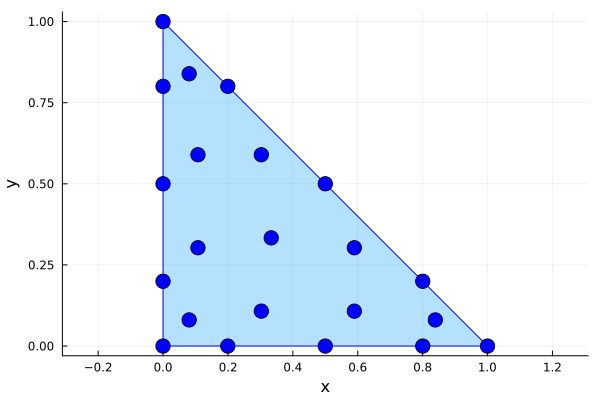

In [7]:
using Plots
# gr()  # Set the backend to GR

# Define the vertices of the triangle
x = [p1[1], p2[1], p3[1], p1[1]]
y = [p1[2], p2[2], p3[2], p1[2]]

# Plot the triangle
plot!(x, y, seriestype = :shape, fillalpha = 0.3, linecolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T1[1, :], T1[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T2[1, :], T2[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T3[1, :], T3[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

scatter!(T4(a[1])[1, :], T4(a[1])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T5(a[2])[1, :], T5(a[2])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)
scatter!(T6(a[3],a[4])[1, :], T6(a[3],a[4])[2, :], markersize = 8, markercolor = :blue, legend = false, aspect_ratio = :equal)

# Add plot title and labels
xlabel!("x")
ylabel!("y")